In [44]:
# import dependencies
from lda_embedder.text_embedder import TextEmbedder
from gensim import corpora, models
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Recommendation by Matrix Factorization

The traditional approach to recommendation is collaborative fil-
tering (CF), where items are recommended to a user based on other users with similar patterns of selected items.

In matrix factorization, we represent users and items in a shared latent low-dimensional space of dimensionK—user i is represented
by

$r_{ij} = u_{i}^{T} v_{j}$

Using this concept, we propose the recommendation system for the business to list most relevant reviews based on latent topics

In [13]:
# load file
business = pd.read_csv('data/chinese_business_clean.csv')
reviews = pd.read_csv('data/chinese_reviews_clean_offsets.csv')

reviews['date_tuple'] = [eval(i) for i in reviews['date_tuple']]
reviews['quarter'] = [eval(i) for i in reviews['quarter']]

In [14]:
# load pretrained topic models
lda =  models.LdaModel.load('data/gensim/lda.model')
dictionary = corpora.Dictionary.load('data/gensim/chinsese_dict.dict')

# load idf matrices
with open('data/u_idf.pickle', 'rb') as f:
    uidf_data = pickle.load(f)
with open('data/b_idf.pickle', 'rb') as f:
    bidf_data = pickle.load(f)
with open('data/b_tfidf.pickle', 'rb') as f:
    btfidf_data = pickle.load(f)

In [15]:
# initialize text embedding classs
embedder = TextEmbedder(model = lda, dictionary = dictionary, user_idf = uidf_data, business_idf = bidf_data, business_tfidf = btfidf_data)

In [16]:
# use top2 growing, declining business for case study
case2 = reviews[reviews['business_id'] == 'pH0BLkL4cbxKzu471VZnuA'] # growing 
case3 = reviews[reviews['business_id'] == 'X8c23dur0ll2D9XTu-I8Qg'] # declining

In [17]:
# embedding helper class
def embed_by_enum(data, embedder, enum = 0, binary = False):
    # select regions
    if binary:
        data = data[data['business_offset'] != 0]
    label = data['business_offset']
    # create labels
    if enum == 2: 
        embed = np.array([embedder.augmented_embed_text(t) for t in data['text'].values])
    elif enum == 3: 
        embed = np.array([embedder.user_tfidf_embed(t, u) for t, u in zip(data['text'].values, data['user_id'].values)])
    elif enum == 4: 
        embed = np.array([embedder.user_tf_business_idf(t, b) for t, b in zip(data['text'].values, data['business_id'].values)])
    elif enum == 5: 
        embed = np.array([embedder.user_tfidf_business_idf(t, u, b) for t, u, b in zip(data['text'].values, data['user_id'].values, data['business_id'].values)])
    
    elif enum == 0: 
        embed = np.array([embedder.embed(t) for t in data['text'].values])
    elif enum == 1:
        embed = np.array([embedder.embed_sent(t) for t in data['text'].values])
    
    elif enum == 6:
        embed = np.array([embedder.augmented_tf_business_tfidf(t, b) for t, b in zip(data['text'].values, data['business_id'].values)])
    else:
        print ('enum {} is not supported'.format(enum))
        return None
    return embed, label

## Method

The matrix factorization is given by $r_{ij} = u_{i}^{T} v_{j}$  

In our case, user vector $u$, is a characteristic vector of each business, and item vector $v$, is a latent embedding of each reviews.

We substitute $u$ with pearson correlation between topics and offsets for each business;
$u_{b} = [\rho_{b0}, \rho_{b1}, ..., \rho_{bk}]$  
where $\rho_{bn}$ is a pearson correlation between performance offsets for business b and topic n.

Also we substitute $v_{d}$ with topic embedding of review d, $\theta_{d}$.

Combining, 
$r_{bd} = [\rho_{b0}, \rho_{b1}, ..., \rho_{bk}]^{T} \theta_{d}$  

In [25]:
def characteristic_vector(embed, label):
    coef = []
    for i in range(len(embed[0])):
        coef.append(np.corrcoef(embed[:,i], label)[0, 1])
    coef = np.array(coef)
    coef[np.isnan(coef)] = 0.0
    return np.array(coef)

Print top most 3 positive/negative reviews found by $r$

In [35]:
def positive_feedbacks(df, n, embed, label):
    vector = characteristic_vector(embed, label)
    dot = np.array([np.dot(d, vector) for d in embed])
    
    pos_idx = np.argsort(dot)[-n:]
    for i in pos_idx[::-1]:
        print ('Rate: {}\n{}\n'.format(df.iloc[i]['stars'], df.iloc[i]['text']))
    return dot

def negative_feedbacks(df, n, embed, label):
    vector = characteristic_vector(embed, label)
    dot = np.array([np.dot(d, vector) for d in embed])
    
    neg_idx = np.argsort(dot)[:n]
    for i in neg_idx:
        print ('Rate: {}\n{}\n'.format(df.iloc[i]['stars'], df.iloc[i]['text']))
    return dot

## Case 1 - SUSHISAMBA

In [67]:
# embedding 
# baseline 
embed1, label1 = embed_by_enum(case2, embedder, enum = 1)
# augmented
embed2, label2 = embed_by_enum(case2, embedder, enum = 2)
# business tfidf 
embed3, label3 = embed_by_enum(case2, embedder, enum = 6)

### Embedding 1

In [68]:
n1 = negative_feedbacks(case2, 3, embed1, label1)

Rate: 1
*bites fist* 

I don't know where to begin... Let me just say I had the worst service by the rudest and most dismissive people at Sushi Samba - ever! 

- The edamame was cold
- Sushi rolls were tasteless 
- Appetizers - tasteless 

I made the waiter aware that I have a shellfish allergy and then I asked questions and ordered my food. When one of my rolls came out the waiter said,"The tempura is fried in the same oil as shellfish, but if you don't care we don't care either!" 

Did you read what I just said he said to me?

Okay, so very confused I handed the cups of tempura back and ate my food very disgusted in how he talked to me. The main waiter pretty much avoided our table. When I told him what was said to me he said,"I don't know why he would say that to you." Wait a minute does basic customer service ever occur to you people? How about you apologize! So he says I'm going to get the manager I said no don't.

He tells the manager anyway and the manager walks over in a drive 

In [69]:
p1 = positive_feedbacks(case2, 3, embed1, label1)

Rate: 5
Love dining here every time I come to Vegas. The atmosphere is great and the food and drinks are worth coming. If you ever have a chance to dine here request Vanessa as your waitress she is incredibly nice and makes sure your dinner is an amazing experience.

Rate: 5
This place deserves 10 stars, by far my favorite restaurant ever, absolutely love it. Every time we go to visit, this is definitely where we go for dinner, it's not cheap but well worth every penny, everything is always so fresh and delicious, and I mean everything, we always try new things along with some of our favorites and we just love this place more and more each time. The service is impeccable, the servers are very professional and very knowledgeable about the menu and drinks, if you are not sure what to get , just let them how much you are willing to spend and they will create a tasting menu for you, believe you will not be disappointed!!!! Their sea bass skewers and Peruvian corn is a must have! I mean eve

### Embedding 2

In [70]:
n2 = negative_feedbacks(case2, 3, embed2, label2)

Rate: 1
Probably the worst sushi restaurant we've been to. Dirty, loud, the service is terrible and the food is even worse. Sent one dish back three times with no resolution. People next to us were complaining as well. Not cheap either, so best to avoid this experience altogether and go somewhere else.

Rate: 3
Not impressed with this Restaraunt. My fiancé food came out late and cold. The waiter mixed up all of the bills. We had to wait on drinks and we never saw our waiter. The water was not refilled and overall customer service experience was poor. However my sushi rolls were great, but a bit on the warm side. It's going to be hard for someone to persuade me to come back here.

Rate: 2
0 star for the food. 
2 stars for the ambiance
0 star for the service

I don't even know where to start. 
Honestly, the reviews are completely deceiving and I was highly disappointed! 
I was so bummed because we were on a really good streak of eating amazing food in Vegas too! 

Straight to the point.


In [71]:
p2 = positive_feedbacks(case2, 3, embed2, label2)

Rate: 5
Wow, what's totally cool Asian fusion sushi place! A Japanese and Spanish Peruvian mix. Service was excellent, attentive without being overbearing, and friendly.

From the menu I tried the Gyoza wagyu beef dumplings. OMG so delicious. Though maybe now I need to try wagyu on it's own. The Kanpachi was simple, well presented and delicious. And the Neo Tokyo (tuna) roll was great as well. A little shochu to go along with it made for an excellent meal.

Highly recommended!

Rate: 4
Came here for dinner last weekend and the hype is real: Sushi Samba is a true winner indeed!

The group I was with ordered many different dishes, and the ones I got to try were the following: 

- Heirloom Salad: I gobbled this up, the dressing has the perfect kick to it. 
- Gyoza: I didn't like this at all, pass. 
- Neo Tokyo: This roll looks intimidating, but it's fabulous. 
- Sao Paolo - The scallop alone on this is mouthwatering. 
- El Topo - A sticky roll, but well worth it if you like cheese. Yum. 


### Embedding 3

In [72]:
n3 = negative_feedbacks(case2, 3, embed3, label3)

Rate: 3
Not impressed with this Restaraunt. My fiancé food came out late and cold. The waiter mixed up all of the bills. We had to wait on drinks and we never saw our waiter. The water was not refilled and overall customer service experience was poor. However my sushi rolls were great, but a bit on the warm side. It's going to be hard for someone to persuade me to come back here.

Rate: 2
Mediocre food. Average service. Very very close seating (had to move tables to get to seat). Overpriced sushi for tiny pieces. Just expected more from such a nice looking place.

Rate: 3
I understand this place is pricey and expected it to be. I can afford a place like this... But apparently the service doesn't treat me like such. 

My friends came here to eat and I came to join them and they got seated at the sushi bar but it took forever for me to get water or anyone to take my order. I wore a cute dress, I have a nice bag, I am clean and freshly showered... But took awhile. They were nice when I or

In [73]:
p3 = positive_feedbacks(case2, 3, embed3, label3)

Rate: 3
This place has some unique flavors going on.  To be totally fair we only tried the appetizers.  The one that stood out in my mind was the duck confit tacos.  Our server was very helpful and attentive.  I think its a must try if you're looking for a quick late night sushi spot for light food.  Much better than the location that closed in Dallas....

Rate: 5
This place is amazing. I went here with a group of 10 and the waitstaff was extremely attentive.  Try the prime rib with truffles and the seabass with miso! I would definitely eat here again!

Rate: 5
The manager Allen was so amazing... I come here a lot! I'm a local and I must say I never get tired of it. On Date night I could eat here every time! My newest obsession is the El Topo! If you are in Vegas please try them out they do not disappoint!



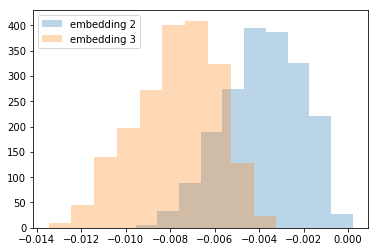

In [79]:
# plt.hist(p1, alpha = 0.3)
plt.hist(p2, alpha = 0.3, label="embedding 2")
plt.hist(p3, alpha = 0.3, label="embedding 3")
plt.legend()
plt.show()

## Analysis

Embedding 1 resulted recommending the review with extreme sentiment (rating 1, rating 5). The contents of reviews seem to capture rather general feedbacks; this is because the embedding tends to become sensitive to the words like 'worst', 'best'. 

Embedding 3, on the other hands, contains more specific topics, such as specific menu, the name of the person etc 

Another interesting take-away is that both of most positive and negative reviews recommended by embedding is rating 3 -- This suggests the sentiment of reviews differ person to person, and the embedding was able to extract reviews based on contents, rather than the rating. 

# Case2 - Hakkasan Nightclub

In [94]:
# embedding 
# baseline 
embed1, label1 = embed_by_enum(case3, embedder, enum = 1)
# augmented
embed2, label2 = embed_by_enum(case3, embedder, enum = 2)
# business tfidf 
embed3, label3 = embed_by_enum(case3, embedder, enum = 6)

### Embedding 1

In [95]:
n1 = negative_feedbacks(case3, 3, embed1, label1)

Rate: 1
Experienced a racist encounter with the security staff. Waiting for a response for management. They have ignored and avoided all of my attempts to reach out to them, extremely unprofessional.

Rate: 1
I'm here right now and am sitting next to someone Who works here who told me if I continue to ask him where my credit card is, which has been gone for 30 minutes - that he  will kick me out. I cannot imagine a worse place to spend my night then a place where people people like this exist.

Rate: 1
The security staff's communication skills with each other is awful. They aren't aware of the events being taken place and they are rude when asked questions. I thought I could come and enjoy a good time with my friends and family only to be led on a goose chase. Everyone I was with was ultimately too frustrated to continue and we decided to go elsewhere.



In [96]:
p1 = positive_feedbacks(case3, 3, embed1, label1)

Rate: 2
Hakkasan has good resident DJ's like Calvin Harris, but the layout of the club is meant for people with bottle service. The dance floor is tiny, and there is pretty much nowhere to sit for people who don't have a table (unless you go to the Ling Ling Lounge, where it's basically empty). If you're able to get a table to let you pass by them to get to the little stage-ish part in front of the dance floor, you can stand there and get a great view. Still had a great time, but wouldn't come back.

Rate: 2
This club's layout is such that unless you have a table(i.e bottle service), you're basically always kind of uncomfortable. The dance floor is too small for the crowd, the second floor's view to the dance floor is completely blocked by the tables there, so people kind of flow around narrow passage ways up and down the club, and look for somewhere to be able to stand. The layout gives you the feel of being in somewhat of a maze, and it basically is such that it gives the feeling of 

### Embedding 2

In [98]:
n1 = negative_feedbacks(case3, 3, embed2, label2)

Rate: 1
If I could give this establishment zero starts, I would. I don't know whether it's legal to charge customers $10 for water when they are drinking, but that's what happened! There was no option for tap water. They said verbatim in several occasions that it is not their policy to supply water free of cost. Someone is going to die.

Rate: 1
If I could give 0 stars i would!  Probably the WORST Club ive ever been to! The Amount of People they let in is Ridiculous to the point you cant even move. 

The Sorry excuse for Bartenders here will ignore you until you somehow manage to pull them your way, they are rude and unfriendly.  A trained monkey can pour a better Jack and Coke. Ordered a Gin and Monster and I got a Red Bull.. ONLY the bull and payed 20 bucks for it. I guess they serve Golden Red Bulls thats what that must have been. It had to be. Wrong! After complaining to the Bar Manager who was even more rude and unhelpful (I see where the "Bartenders" get their manners from) I fin

In [99]:
p1 = positive_feedbacks(case3, 3, embed2, label2)

Rate: 4
I don't know why Hakkasan only has 2.5 star. I had a great time there. Only down side was the over the top priced drinks.

Rate: 5
When in Vegas this is a must. We went when Lil Jon was the deejay he had the place lit. Great atmosphere and great music only complaint would be the drinks are a bit pricey but thats Vegas for you. I definitely recommend

Rate: 5
I love this place me and my hubby celebrated our third anniversary there and everyone is so nice and helpful. they also have different sections to the club incas you don't like the music not only that they have an awesome sounds system! awesome lighting 
I will definitely go back!



### Embedding 3

In [101]:
n1 = negative_feedbacks(case3, 3, embed3, label3)

Rate: 1
If I could give 0 stars i would!  Probably the WORST Club ive ever been to! The Amount of People they let in is Ridiculous to the point you cant even move. 

The Sorry excuse for Bartenders here will ignore you until you somehow manage to pull them your way, they are rude and unfriendly.  A trained monkey can pour a better Jack and Coke. Ordered a Gin and Monster and I got a Red Bull.. ONLY the bull and payed 20 bucks for it. I guess they serve Golden Red Bulls thats what that must have been. It had to be. Wrong! After complaining to the Bar Manager who was even more rude and unhelpful (I see where the "Bartenders" get their manners from) I finally got what i thought was my drink but it turned out to be just water. So they charged me $20 for a redbull and a glass of water. 

After further complaining they just decided to kick my friends and myself out because they didt wanna fix the problem they caused.  

Long story short this place is NOTHING more than a piece of Garbage,  pe

In [102]:
p1 = positive_feedbacks(case3, 3, embed3, label3)

Rate: 4
I don't know why Hakkasan only has 2.5 star. I had a great time there. Only down side was the over the top priced drinks.

Rate: 5
Fun and great place!

Partied here recently in Vegas...what an amazing time.

Great memories and dancing here.

Rate: 5
When in Vegas this is a must. We went when Lil Jon was the deejay he had the place lit. Great atmosphere and great music only complaint would be the drinks are a bit pricey but thats Vegas for you. I definitely recommend



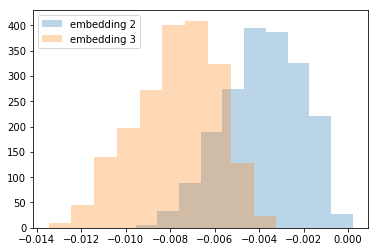

In [103]:
# plt.hist(p1, alpha = 0.3)
plt.hist(p2, alpha = 0.3, label="embedding 2")
plt.hist(p3, alpha = 0.3, label="embedding 3")
plt.legend()
plt.show()

## Analysis 

The embedding 1 failed to extract reviews with positive sentiment while other embeddings were able to filter positive reviews.